# Ahmed Alrabiah

### Importing the necessary libraries:

In [1]:
import scipy
from scipy import integrate
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython import display

import numpy as np

import timeit

%matplotlib inline
plt.rcParams['animation.ffmpeg_path'] = '/Library/anaconda3/bin/ffmpeg'

In [2]:
start = timeit.default_timer() # To measure the run time of the code

# Animation function

### A function that takes the wavefunction and simulate its movements at different specific times to create a video

In [3]:
def simulate(psi): # This function creates the animation at different times upon call
    def animate(i):
        ln1.set_data(x, np.absolute(psi[:,1*i])**2)

    fig, ax = plt.subplots(1,1, figsize=(8,4))
    #ax.grid()
    ln1, = plt.plot([], [], 'darkslateblue', lw=2, markersize=8, label = "Wave packet")
    time_text = ax.text(0.65, 16, '', fontsize=15,
               bbox=dict(facecolor='white', edgecolor='black'))
    ax.set_ylim(-0.1, 1.2)
    ax.set_xlim(0, 20)
    ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
    ax.set_xlabel('$x$', fontsize=20)
    plt.tight_layout()
    plt.plot(x, V, 'y--', label = 'Potential V')
    ax.legend(loc='upper left')
    ani = animation.FuncAnimation(fig, animate, frames=200, interval=50)

    video = ani.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

# The method used to solve the time-dependent Schrödinger equation

Time-dependent Schrödinger equation:


### $i \hbar \frac{\partial \psi}{\partial t} = -\frac{\hbar^2}{2m} \frac{\partial^2 \psi}{\partial x^2} + V(x) \psi $

Using the finite different method to discretize the second spatial derivative:

### $ \frac{\partial^2 \psi}{\partial x^2} = \frac{1}{(\delta x)^2} \times [\psi_{n+1} - 2 \psi_{n} + \psi_{n-1}] $

in which it can be represented as an $n \times n$ sparse matrix:

\begin{align}
\frac{\partial^2 \psi}{\partial x^2}
&= 
\frac{1}{(\delta x)^2}
\begin{pmatrix}
  2 & -1 & 0 & \dots & 0\\ 
  -1 & 2 & -1 & \dots & 0 \\
  0 & \ddots & \ddots & \ddots & \vdots \\
  \vdots &  &  &  & -1 \\
  0 & \dots & 0 & -1 & 2
\end{pmatrix}
\cdot
\begin{pmatrix}
   \psi_1 \\
   \psi_2 \\
   \vdots \\
   \vdots \\
   \psi_n  
\end{pmatrix}
&\equiv
\frac{1}{(\delta x)^2} H \cdot \Psi
\end{align}

Therefore,

### $i \hbar \frac{\partial \psi}{\partial t} = -\frac{\hbar^2}{2m} \frac{1}{(\delta x)^2} H \cdot \Psi + V(x) \Psi $

Divide by $i \hbar$:

### $\frac{\partial \psi}{\partial t} = i (\frac{\hbar}{2m} \frac{1}{(\delta x)^2} H \cdot \Psi - \frac{V(x)}{\hbar} \Psi) $

With the given initial wavefunction:

### $ \psi(x, 0) = e^{i p_0 x} e^{-a ( x - x_0)^2 / 2} $

where $ x_0 = 4; \;\; p_0 = 20; \;\; a = 2 $ and $x$ is a discrete variable, we use an initial-value problem integration from scipy to get the time evolved wavefunction $\Psi(x, t)$.

# Create a discretized grid for spatial and temporal elements:

$x$ goes from $0$ to $20$ with $500$ steps in between; $dx = 0.04$

$t$ goes from $0$ to $0.5$ with $200$ steps in between; $dt = 0.0025$

In [4]:
x = np.linspace(0, 20, 500) # discrete position line

dx = (max(x) - min(x))/len(x) # Spatial step width
    
times = np.linspace(0, 0.5, 200) # discrete time line

t0 = min(times) # initial time

tf = max(times) # final time

dt = (tf - t0)/len(times)  # temporal step width

# Wavefunction:

### The following function takes a potential array, that represents the value of the potential at the different discrete positions, and gives the time evolved wavefunction.

In [5]:
def wavefunction(V): # Function definition
    
    # Initial Wavefunction
    h = 1; m = 1/2; x0 = 4; p0 = 20; a = 2 # Parameters
    psi0 = np.exp(1j * p0 * x) * np.exp((-a * (x - x0)**2)/2)

    # H matrix
    H = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(len(x), len(x))) / dx**2

    # A function that gives the derivative of the wavefunction wrt time in terms of discrete H and v
    def psi_t(t, psi):
        return -1j * (- h/(2*m) * H.dot(psi) + V/h * psi)


    # Solving the initial value problem to get the time evolved wavefunction
    sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = times)
    
    return sol.y

## Without potential ($V = 0$):

In [6]:
# Potential V(x)
V = np.zeros(x.shape) # Creating a list of zeros

In [7]:
psi = wavefunction(V) # Calling the wavefunction function given the zero potential

In [8]:
simulate(psi)

The probability at time $ t = 0 $:

In [9]:
np.sum(np.absolute(psi[:,0])**2) * dx

1.2508075090408688

#### Note that the wave function at $t = 0$ is normalized to $ \sim 1.25 $

### Next we check that the probability is conserved

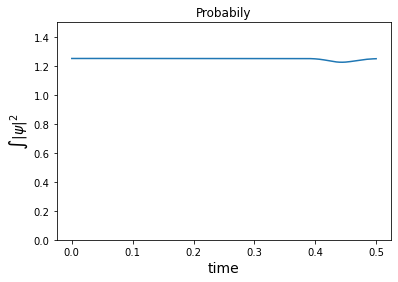

In [10]:
T = [] # An empty list to be filled with the probability value at all times

for t in range(len(times)): # A loop over different times to find the probability value
    T.append(scipy.integrate.trapz(np.absolute(psi[:,t])**2, dx=dx))

# Plotting
plt.figure()
plt.plot(np.linspace(t0, tf, len(T)), T)
plt.ylim(0, 1.5)
plt.xlabel('time', fontsize=14)
plt.ylabel('$\int |\psi|^2$', fontsize=14)
plt.title('Probabily')
plt.show()

### Notice that the probability is constant over all times implying that probability is conserved; the dip towards the end is due to the iteraction of the wave with the end wall.

## With  $V = \begin{cases} 
      400 & if \;\; 9.9 \leq x \leq 10.1 \\
      0   & \;\;\;\;\; otherwise
   \end{cases}$:

In [11]:
# Potential V(x)
V = np.zeros(len(x)) # A list filled with zeros
for i, _x in enumerate(x):
    if 9.9 <= _x <= 10.1:
        V[i] = 400

In [12]:
psi = wavefunction(V) # Calling the wavefunction function

In [13]:
simulate(psi)

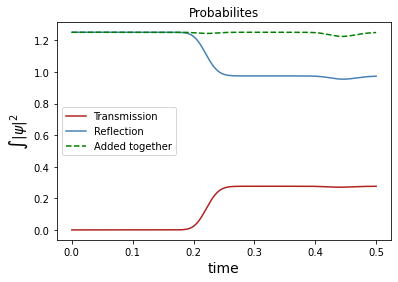

In [14]:
T = []
R = []
for t in range(len(times)):
    T.append(scipy.integrate.trapz(np.absolute(psi[300: 500,t])**2, dx=dx))
    R.append(scipy.integrate.trapz(np.absolute(psi[0:300,t])**2, dx=dx))

plt.figure()
plt.plot(times, T, 'firebrick', label = 'Transmission')
plt.plot(times, R, 'steelblue', label = 'Reflection')
plt.plot(times, np.add(T, R), 'g--', label = 'Added together')
plt.legend(loc='center left')
plt.xlabel('time', fontsize=14)
plt.ylabel('$\int|\psi|^2$', fontsize=14)
plt.title('Probabilites')
plt.show()

### We can see in the probabilites figure that the reflection and transmission probabilites add to the normalization value ($\sim 1.25$) which is what it should be.

In [15]:
end = timeit.default_timer()
print("Running time:")
print(end-start, 'seconds')
print((end-start)/60, 'minutes')

Running time:
9.758157708 seconds
0.1626359618 minutes
